## Model labels error

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import * 
from fastai.vision import *

from pathlib import Path
import json 
from matplotlib import patches, patheffects
import os 
import collections
import pandas as pd

### Dataset preparation

The file boxes has the following format: 
imagename,bb,class

The file is also in the repository with some sample images

In [22]:
imgs = [] 
img_file = open('data/boxes.csv', 'r')
for line in img_file: 
    en = line.strip().split(',') 
    imgs.append( (en[0], [int(i) for i in en[1].split()] , en[2]))

In [23]:
images = [ str(i[0]) for i in imgs ]
lbl_bbox = [ [ [ i[1] ] , [ i[2]] ] for i in imgs]
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [26]:
data = (ObjectItemList.from_folder('data/imgs')
        .split_none()                          
        .label_from_func(get_y_func)
        .transform(None, size=224, tfm_y=True, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=3, collate_fn=bb_pad_collate, num_workers=0))   

### Visualization
If we show a batch, we can see that the labels are 0 and 1, exactly as in the file.

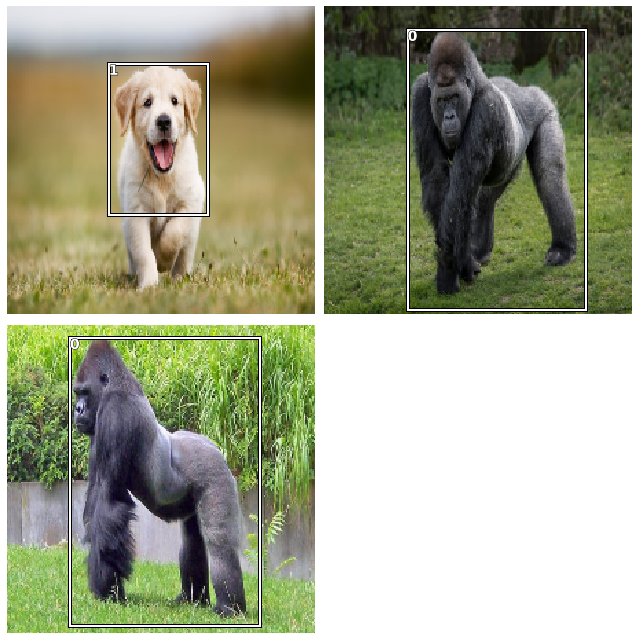

In [27]:
data.show_batch(2, figsize=(9,9))

### Model preparation 
We'll use a resnet34 with a custom loss function. 

In [28]:
f_model = models.resnet34
sz=224

labels = set([ i[2] for i in imgs ])
n_classes = len(labels)

For some reason, the loss function is not accepting a single target but 2 (one for the bounding boxes and one for the classes). This is different as what Jaimie showed in the lesson 9 of 2018 (maybe the change is due to the fastai version change?).

Also, a reshape of the target2 (the classes) needst to be done. Target2 shape is (bs,1) and it's transformed to (bs). 

I'm adding a print statement showing the target classes to show that the labels are modified from (0,1) to (1,2).

In [29]:
def detn_loss(input, target1, target2):
    h,w = target2.shape
    target2 = target2.reshape(h)
    bb_t, c_t = target1, target2
    print("Target classes %s" % c_t)
    bb_i, c_i = input[:,:4], input[:, 4:]
    bb_i = F.torch.sigmoid(bb_i) * 224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * 20

The first line of the output of the next command is showing that the classes were transformed from [0,0,1] to [1,1,2]. The traceback shows that the cross_entropy function is failing because there is a class that is not fullfilling the requirement of `cur_target < n_classes`

In [30]:
head_reg = nn.Sequential(
    Flatten(),
    nn.Linear(25088, 4 + n_classes)
)
learn = cnn_learner(data, f_model, custom_head=head_reg)
learn.opt_fn = optim.Adam
learn.loss_func = detn_loss
learn.lr_find()

Target classes tensor([1, 1, 2])


/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([3, 1, 4])) that is different to the input size (torch.Size([3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at ../aten/src/THNN/generic/ClassNLLCriterion.c:92